### Analysis of PAR-2 membrane association in polarised vs uniform cells

Context:
- Comparing membrane to cytoplasmic ratio in polarised vs uniform cells to assess cooperative membrane association

Results:
- For wild type PAR-2, affinity is higher in polarised cells, implying nonlinear membrane association kinetics
- For RING mutants (C56S, L109R), this difference is lost

Dependencies:
- Relies on quantification data generated using the _Run/par2_nebd_quantify.ipynb_ notebook   


In [1]:
import sys, os, glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
sys.path.append('../../..')
from src import bounded_mean_1d, lighten, load_image, rotated_embryo, raw_data_path, dataplot, bootstrap_effect_size_pd, add_stats_table_row
import matplotlib.transforms as transforms
from matplotlib.legend_handler import HandlerTuple
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

if not os.path.exists('Figs'):
    os.mkdir('Figs')

### Quantification

In [2]:
# Import embryos dataframe
df = pd.read_csv("../../../data/par2_nebd_embryos.csv")
if raw_data_path:
    df["Path"] = df["Path"].apply(lambda x: raw_data_path + x)

# Select relevant embryos
df = df[df.Line.isin(["lp637", "nwg201", "nwg240", "nwg246", "nwg338", "nwg369"])]
df = df[df.RNAi == "wt"]

# Add columns
unipol = ["Pol" if x in ["lp637", "nwg240", "nwg338"] else "Uni" for x in df.Line]
df["UniPol"] = unipol
genotype = [
    "WT"
    if x in ["lp637", "nwg201"]
    else "C56S"
    if x in ["nwg240", "nwg246"]
    else "L109R"
    for x in df.Line
]
df["Genotype"] = genotype

# Import and filter quantification dataframe
df_quantification = pd.read_csv("../../../data/par2_nebd_quantification.csv")
df_quantification = df_quantification[
    df_quantification.EmbryoID.isin(df.EmbryoID.tolist())
]

# Summary quantification
df_summary = pd.DataFrame()
for i, r in df_quantification.groupby("EmbryoID"):
    cyt = np.mean(r["Cytoplasmic signal"])
    mem_tot = np.mean(r["Membrane signal"])
    mem_ant = bounded_mean_1d(r["Membrane signal"], [0.4, 0.6])
    mem_post = bounded_mean_1d(r["Membrane signal"], [0.9, 0.1])
    ratio_post = mem_post / cyt
    p = {
        "EmbryoID": i,
        "Cyt": cyt,
        "Mem_tot": mem_tot,
        "Mem_ant": mem_ant,
        "Mem_post": mem_post,
        "Ratio post": ratio_post,
    }
    df_summary = df_summary.append(pd.DataFrame(p, index=[i]))

# Merge with embryos dataframe
df = pd.merge(df, df_summary, on="EmbryoID")

### Plot: WT vs C56S quantification

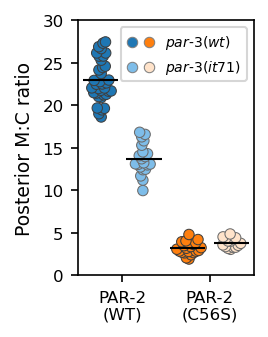

In [3]:
_df = df[df.Line.isin(["lp637", "nwg201", "nwg240", "nwg246"])]

# Set up figure
fig, ax = plt.subplots()
fig.set_size_inches(7, 2.5)
offset = lambda p: transforms.ScaledTranslation(p / 72.0, 0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

# Colour palettes
palette1 = {"WT": "tab:blue", "C56S": "tab:orange"}
palette2 = {_: lighten(__, 1.7) for _, __ in palette1.items()}
order = ["WT", "C56S"]

# Plot polarised data
dataplot(
    data=_df[_df.UniPol == "Pol"],
    x="Genotype",
    y="Ratio post",
    ax=ax,
    order=order,
    hue="Genotype",
    palette=palette1,
    transform=trans + offset(-10),
    linewidth=0.5,
    offset=-0.25,
)

# Plot uniform data
dataplot(
    data=_df[_df.UniPol == "Uni"],
    x="Genotype",
    y="Ratio post",
    ax=ax,
    order=order,
    hue="Genotype",
    palette=palette2,
    transform=trans + offset(10),
    linewidth=0.5,
    offset=0.25,
)

# Legend
s = 25
top_left = ax.scatter([], [], linewidth=0.5, edgecolors="gray", color="tab:blue", s=s)
top_right = ax.scatter(
    [], [], linewidth=0.5, edgecolors="gray", color="tab:orange", s=s
)
bottom_left = ax.scatter(
    [], [], linewidth=0.5, edgecolors="gray", color=lighten("tab:blue", 1.7), s=s
)
bottom_right = ax.scatter(
    [], [], linewidth=0.5, edgecolors="gray", color=lighten("tab:orange", 1.7), s=s
)
ax.legend(
    [(top_left, top_right), (bottom_left, bottom_right)],
    [r"$par$" + "-" + r"$3(wt)$", r"$par$" + "-" + r"$3(it71)$"],
    fontsize=6.7,
    handler_map={tuple: HandlerTuple(ndivide=None)},
)

# Finalise plot
ax.set_xticklabels(["PAR-2\n(WT)", "PAR-2\n(C56S)"])
ax.tick_params(axis="both", labelsize=8)
ax.set_xlabel("")
ax.set_ylim(0, 30)
ax.set_ylabel("Posterior M:C ratio", fontsize=9)
fig.set_size_inches(1.8, 2.5)
fig.subplots_adjust(left=0.25, bottom=0.2)
fig.savefig("Figs/mc_ratio.png", dpi=600, transparent=True)

In [4]:
# Effect of uniform vs polarised for wt data
es1 = bootstrap_effect_size_pd(
    data=_df[_df.Genotype == "WT"], x="UniPol", y="Ratio post", a="Pol", b="Uni"
)
add_stats_table_row(
    figure="1",
    panel="E",
    sample_a="PAR-2(WT); par-3(wt)",
    sample_b="PAR-2(WT); par-3(it71)",
    measure='Posterior M:C ratio',
    comparisons=es1,
    key='bPBbMV2LIL'
)

# Effect of uniform vs polarised for C56S data
es2 = bootstrap_effect_size_pd(
    data=_df[_df.Genotype == "C56S"], x="UniPol", y="Ratio post", a="Pol", b="Uni"
)
add_stats_table_row(
    figure="1",
    panel="E",
    sample_a="PAR-2(C56S); par-3(wt)",
    sample_b="PAR-2(C56S); par-3(it71)",
    measure='Posterior M:C ratio',
    comparisons=es2,
    key='HS6YU5pQ5U'
)

### Images: WT vs C56S (Raw/SAIBR composite)

In [5]:
def image_panel_comp(ax, path, scale_bar=False, border="tab:blue"):
    roi = np.loadtxt(path + "/ROI_fit.txt")
    img1 = load_image(path + "/af_corrected.tif")
    img2 = load_image(glob.glob(path + "/*488 SP 535-50*.TIF")[0])
    rotated1 = rotated_embryo(img1, roi, 230, 180, 3)
    rotated2 = rotated_embryo(img2, roi, 230, 180, 3)
    rotated = rotated1

    # Line through the middle
    mask1 = np.concatenate((np.ones([90, 230]), np.zeros([90, 230])), axis=0)
    mask2 = np.concatenate((np.zeros([90, 230]), np.ones([90, 230])), axis=0)

    ax.imshow(rotated2, cmap="gray", vmin=0, vmax=40866.22508001195, alpha=mask1)
    ax.imshow(rotated1, cmap="gray", vmin=0, vmax=33648.54240741733, alpha=mask2)
    ax.set_xticks([])
    ax.set_yticks([])
    [spine.set_edgecolor(border) for spine in ax.spines.values()]
    [spine.set_linewidth(3) for spine in ax.spines.values()]

    if scale_bar:
        px = 0.255  # pixel size
        bar_length = 10  # microns
        bar_pixels = bar_length / px
        y = rotated.shape[0] - 10
        ax.plot(
            [rotated.shape[1] - 10 - bar_pixels, rotated.shape[1] - 10],
            [y, y],
            color="w",
            linewidth=2,
        )
        ax.text(s="Raw", x=10, y=25, c="w", fontsize=10)
        ax.text(s="SAIBR", x=10, y=170, c="w", fontsize=10)


if raw_data_path:
    fig, ax = plt.subplots(2, 2)
    image_panel_comp(
        ax[0][0],
        df[(df.Genotype == "WT") * (df.UniPol == "Pol")].Path.iloc[0],
        scale_bar=True,
        border="tab:blue",
    )
    image_panel_comp(
        ax[0][1],
        df[(df.Genotype == "WT") * (df.UniPol == "Uni")].Path.iloc[1],
        border=lighten("tab:blue", 1.7),
    )
    image_panel_comp(
        ax[1][0],
        df[(df.Genotype == "C56S") * (df.UniPol == "Pol")].Path.iloc[0],
        border="tab:orange",
    )
    image_panel_comp(
        ax[1][1],
        df[(df.Genotype == "C56S") * (df.UniPol == "Uni")].Path.iloc[0],
        border=lighten("tab:orange", 1.7),
    )
    fig.set_size_inches(4, 3)
    fig.subplots_adjust(wspace=-0.05, hspace=0.15)
    fig.savefig("Figs/embryos_composite.png", dpi=600, transparent=True)

### Plot: WT vs L109R quantification

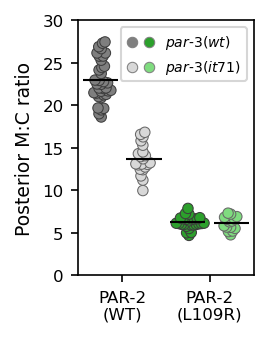

In [6]:
_df = df[df.Line.isin(["lp637", "nwg201", "nwg338", "nwg369"])]

palette1 = {"WT": "tab:gray", "L109R": "tab:green"}
palette2 = {_: lighten(__, 1.7) for _, __ in palette1.items()}
order = ["WT", "L109R"]

fig, ax = plt.subplots()
fig.set_size_inches(7, 2.5)
offset = lambda p: transforms.ScaledTranslation(p / 72.0, 0, plt.gcf().dpi_scale_trans)
trans = plt.gca().transData

dataplot(
    data=_df[_df.UniPol == "Pol"],
    x="Genotype",
    y="Ratio post",
    ax=ax,
    order=order,
    hue="Genotype",
    palette=palette1,
    transform=trans + offset(-10),
    linewidth=0.5,
    offset=-0.25,
)
dataplot(
    data=_df[_df.UniPol == "Uni"],
    x="Genotype",
    y="Ratio post",
    ax=ax,
    order=order,
    hue="Genotype",
    palette=palette2,
    transform=trans + offset(10),
    linewidth=0.5,
    offset=0.25,
)

# Legend
s = 25
top_left = ax.scatter([], [], linewidth=0.5, edgecolors="gray", color="tab:gray", s=s)
top_right = ax.scatter([], [], linewidth=0.5, edgecolors="gray", color="tab:green", s=s)
bottom_left = ax.scatter(
    [], [], linewidth=0.5, edgecolors="gray", color=lighten("tab:gray", 1.7), s=s
)
bottom_right = ax.scatter(
    [], [], linewidth=0.5, edgecolors="gray", color=lighten("tab:green", 1.7), s=s
)
ax.legend(
    [(top_left, top_right), (bottom_left, bottom_right)],
    [r"$par$" + "-" + r"$3(wt)$", r"$par$" + "-" + r"$3(it71)$"],
    fontsize=6.7,
    handler_map={tuple: HandlerTuple(ndivide=None)},
)

ax.set_xticklabels(["PAR-2\n(WT)", "PAR-2\n(L109R)"])
ax.tick_params(axis="both", labelsize=8)
ax.set_xlabel("")
ax.set_ylim(0, 30)
ax.set_ylabel("Posterior M:C ratio", fontsize=9)
fig.set_size_inches(1.8, 2.5)
fig.subplots_adjust(left=0.25, bottom=0.2)
fig.savefig("Figs/mc_ratio_l109r.png", dpi=600, transparent=True)

In [7]:
# Effect of uniform vs polarised for L109R data
es2 = bootstrap_effect_size_pd(
    data=_df[_df.Genotype == "L109R"], x="UniPol", y="Ratio post", a="Pol", b="Uni"
)
add_stats_table_row(
    figure="2",
    panel="I",
    sample_a="PAR-2(L109R); par-3(wt)",
    sample_b="PAR-2(L109R); par-3(it71)",
    measure='Posterior M:C ratio',
    comparisons=es2,
    key='Gnxh2lFfC3'
)